In [1]:
batch_size = 4000
lr = 0.0001
num_epoch = 500
number_of_features = 17
hyper_parameter1=128
hyper_parameter2=64
hyper_parameter3=32
hyper_parameter4=16

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data.dataset import Dataset
from torch.utils.data import random_split, DataLoader
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt

# GPU OR CPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

GPU


In [4]:
class DataSet_Loader(Dataset):

    def __init__(self,data_set_path):
        df = pd.read_excel(data_set_path)
        # print(df.msg_cat.value_counts().sort_values().plot(kind = "barh"))
        # print(df['msg_cat'].value_counts())

        # # preprocceing
        df=df[['QTITTRAN','IANUTRAN','IGARTRANCHC','DHTRAN','CIDGRC','TDECOMP','ACAROMDENACKL_CIDADFEMET','ACAROMDENACKL_YCPTEOM','ACAROMDENACKL_NCPTEPOSIPTOM','ACAROMDENACKL_DHSAIOMADF','ACAROMDENACKL_YPLIMSAIOM','ACAROMDENACKL_YVALIOMNSC','ACAROMDENACKL_YOM','ACAROMDENACKL_IPRSQTITREST','ACAROMDENACKL_CIDITF','ACAROMDENACKL_PLIMSAIOM_QMT','INSTRUMENTID','PTRAN_QMT']]
        df['CIDGRC']=df['CIDGRC'].astype("string")
        df['ACAROMDENACKL_YPLIMSAIOM']=df['ACAROMDENACKL_YPLIMSAIOM'].astype("string")
        df['ACAROMDENACKL_YVALIOMNSC']=df['ACAROMDENACKL_YVALIOMNSC'].astype("string")
        df['ACAROMDENACKL_YOM']=df['ACAROMDENACKL_YOM'].astype("string")
        df['ACAROMDENACKL_CIDITF']=df['ACAROMDENACKL_CIDITF'].astype("string")
        df['INSTRUMENTID']=df['INSTRUMENTID'].astype("string")

        cols = ['CIDGRC' ,'ACAROMDENACKL_YPLIMSAIOM','ACAROMDENACKL_YVALIOMNSC','ACAROMDENACKL_CIDITF','ACAROMDENACKL_YOM','ACAROMDENACKL_NCPTEPOSIPTOM','ACAROMDENACKL_DHSAIOMADF','INSTRUMENTID']
        df[cols] = df[cols].apply(LabelEncoder().fit_transform)

        self.data_array = df.values
        self.x = self.data_array[:, :17]
        self.y = self.data_array[:, 17]

        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

In [5]:
dataset_trades = DataSet_Loader("/content/drive/MyDrive/M1.xlsx")
number_of_test = int(len(dataset_trades)*0.3)
number_of_train = len(dataset_trades) - int(len(dataset_trades)*0.3)
train_trade ,test_trade = random_split(dataset=dataset_trades, lengths=[number_of_train,number_of_test])

train_trade_dataloader = DataLoader(dataset=train_trade ,batch_size=batch_size ,shuffle=True)
test_trade_dataloader = DataLoader(dataset=test_trade ,batch_size=batch_size ,shuffle=True)
dataset_trades.x

tensor([[-0.3529,  0.0000,  0.0000,  ...,  0.7266, -0.5234,  1.1742],
        [-0.3549,  0.0000,  0.0000,  ...,  0.8418, -0.5234,  1.1742],
        [-0.3569,  0.0000,  0.0000,  ...,  0.8994, -0.5233,  1.1742],
        ...,
        [-0.3267,  0.0000,  0.0000,  ...,  0.0931, -0.0911,  0.1338],
        [-0.2826,  0.0000,  0.0000,  ..., -0.8284,  0.0839,  1.4028],
        [-0.1652,  0.0000,  0.0000,  ...,  1.3025, -0.5103,  1.0713]])

In [6]:
class Model_Nerual_FL(nn.Module):

    def __init__(self):
        super(Model_Nerual_FL, self).__init__()

        self.layers = nn.Sequential(
        nn.Linear(number_of_features, hyper_parameter1),
        nn.Tanh(),
        nn.Linear(hyper_parameter1, hyper_parameter2),
        nn.Tanh(),
        nn.Linear(hyper_parameter2, hyper_parameter3),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter3, hyper_parameter4),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter4,1)
        )

    def forward(self,x):
        return self.layers(x)

In [7]:
model_Nerual_FL = Model_Nerual_FL().to(device=device)
model_Nerual_FL

Model_Nerual_FL(
  (layers): Sequential(
    (0): Linear(in_features=17, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [9]:
def federated_train(num_epochs, train_msg_cat_dataloader,local_model, optimizer, loss_fn, device):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    start.record()

    loss_plot = []

    for epoch in range(num_epochs+1):
        for batch_x, batch_y in train_msg_cat_dataloader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            batch_x, batch_y = batch_x.float(), batch_y.float().reshape((batch_y.shape[0], 1))

            optimizer.zero_grad()
            output = local_model(batch_x)
            loss = loss_fn(output,batch_y)
            # print("Output shape:", output.shape)
            # print("Target shape:", batch_y.shape)
            loss.backward()
            optimizer.step()

        if epoch % 50 == 0:
            print("Epoch [%d/%d], Loss: %.4f" % (epoch, num_epochs, loss.item()))
            loss_plot.append(loss.item())

    end.record()
    # Waits for everything to finish running
    torch.cuda.synchronize()

    execution_time = start.elapsed_time(end) / 1000.0  # Convert to seconds

    print("Execution Time: %.4f seconds" % execution_time)

    plt.plot(range(len(loss_plot)), np.asarray(loss_plot))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()


In [10]:
def federated_learning(num_clients, client_data_loaders, global_model, optimizer, loss_fn, device):
    for client_id, client_dataloader in enumerate(client_data_loaders):
        local_model = Model_Nerual_FL().to(device)
        local_model.load_state_dict(global_model.state_dict())  # Initialize local model with global model parameters
        federated_train(num_epoch, client_dataloader, local_model, optimizer, loss_fn, device)
        # After training on client data, send the updated model to the server for aggregation
        global_model.load_state_dict(local_model.state_dict())  # Update global model with local model's parameters


Epoch [0/500], Loss: 708938.3125
Epoch [50/500], Loss: 708938.3750
Epoch [100/500], Loss: 708938.3125
Epoch [150/500], Loss: 708938.3750
Epoch [200/500], Loss: 708938.3750
Epoch [250/500], Loss: 708938.3750
Epoch [300/500], Loss: 708938.3750
Epoch [350/500], Loss: 708938.3125
Epoch [400/500], Loss: 708938.3125
Epoch [450/500], Loss: 708938.3750
Epoch [500/500], Loss: 708938.3125
Execution Time: 29.4914 seconds


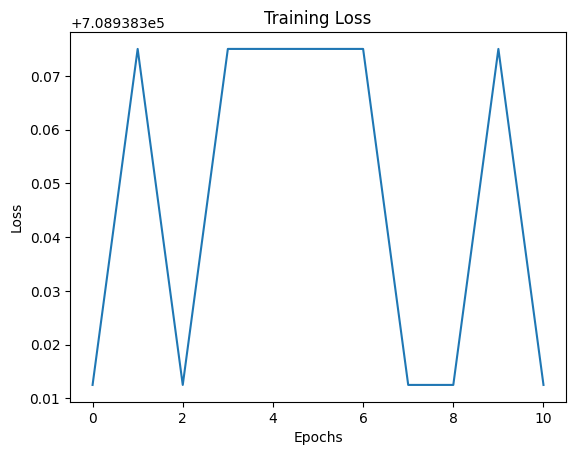

Epoch [0/500], Loss: 708938.3750
Epoch [50/500], Loss: 708938.3750
Epoch [100/500], Loss: 708938.3125
Epoch [150/500], Loss: 708938.3125
Epoch [200/500], Loss: 708938.3750
Epoch [250/500], Loss: 708938.3125
Epoch [300/500], Loss: 708938.3125
Epoch [350/500], Loss: 708938.3750
Epoch [400/500], Loss: 708938.3750
Epoch [450/500], Loss: 708938.3750
Epoch [500/500], Loss: 708938.3750
Execution Time: 19.6472 seconds


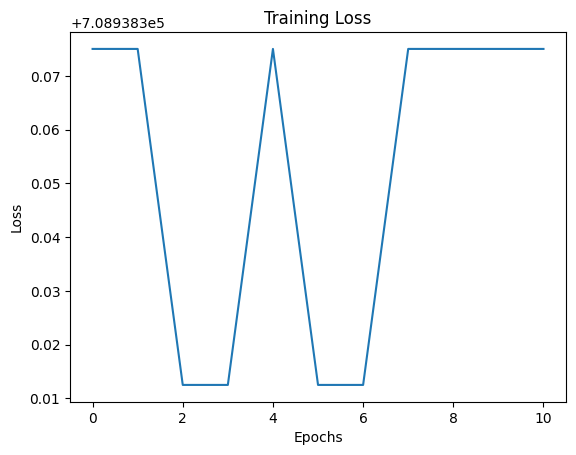

Epoch [0/500], Loss: 708938.3125
Epoch [50/500], Loss: 708938.3750
Epoch [100/500], Loss: 708938.3750
Epoch [150/500], Loss: 708938.3125
Epoch [200/500], Loss: 708938.3750
Epoch [250/500], Loss: 708938.3125
Epoch [300/500], Loss: 708938.3125
Epoch [350/500], Loss: 708938.3125
Epoch [400/500], Loss: 708938.3750
Epoch [450/500], Loss: 708938.3750
Epoch [500/500], Loss: 708938.3125
Execution Time: 18.9911 seconds


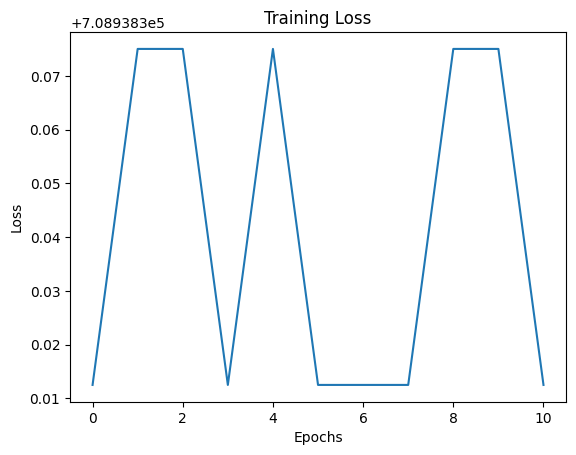

In [11]:
num_clients = 3
global_model = Model_Nerual_FL().to(device=device)
optimizer = opt.Adam(global_model.parameters(), lr=lr)
loss_fn = nn.BCEWithLogitsLoss()

# Assume you have client data loaders for each client
client_data_loaders = [
                        DataLoader(dataset=train_trade ,batch_size=batch_size ,shuffle=True),
                        DataLoader(dataset=train_trade ,batch_size=batch_size ,shuffle=True),
                        DataLoader(dataset=train_trade ,batch_size=batch_size ,shuffle=True),

                        ]

# Run federated learning
federated_learning(num_clients, client_data_loaders, global_model, optimizer, loss_fn, device)


In [12]:

y_test, yhat = list(), list()


model_Nerual_FL.eval()  # Set the model to evaluation mode
total_correct = 0
total_samples = 0
criterion = nn.BCEWithLogitsLoss()

with torch.no_grad():  # Disable gradient computation for evaluation
    for inputs, targets in test_trade_dataloader:
        inputs = inputs.to(device).float()
        targets = targets.to(device).float()

        outputs = global_model(inputs)
        loss = criterion(outputs, targets.reshape((targets.shape[0], 1)))
        _, predicted = torch.max(outputs, 1)

        total_correct += (predicted == targets).sum().item()
        total_samples += targets.size(0)

        for i in targets.cpu().detach().numpy():
            y_test.append(i)
        for i in predicted.cpu().detach().numpy():
            yhat.append(i)

accuracy = total_correct / total_samples
print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.0000
